# Exploring the New Sample Dataset

**Goal**: Test the weighting and hard cut config of the data loading process

In [3]:
%load_ext autoreload
%autoreload 2

import os
import yaml
import logging

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from itertools import chain
import seaborn as sns

logging.basicConfig(level=logging.INFO)

/global/homes/d/danieltm/.conda/envs/gnn4itk/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data load

In [4]:
input_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/jan_files/ITKEvents4Paper2023/NewITkSamples_ttbar_test1/J101_0"
input_files = os.listdir(input_dir)
input_files = sorted([os.path.join(input_dir, f) for f in input_files])

In [6]:
cluster_file = "/global/cfs/cdirs/m3443/data/ITk-upgrade/jan_files/ITKEvents4Paper2023/NewITkSamples_ttbar_test1/J101_0/clusters_evt1.txt"
particles_file = "/global/cfs/cdirs/m3443/data/ITk-upgrade/jan_files/ITKEvents4Paper2023/NewITkSamples_ttbar_test1/J101_0/particles_evt1.txt"
spacepoints_file = "/global/cfs/cdirs/m3443/data/ITk-upgrade/jan_files/ITKEvents4Paper2023/NewITkSamples_ttbar_test1/J101_0/spacepoints_evt1.txt"
tracks_file = "/global/cfs/cdirs/m3443/data/ITk-upgrade/jan_files/ITKEvents4Paper2023/NewITkSamples_ttbar_test1/J101_0/tracks_evt1.txt"
detailed_tracks_file = "/global/cfs/cdirs/m3443/data/ITk-upgrade/jan_files/ITKEvents4Paper2023/NewITkSamples_ttbar_test1/J101_0/detailedtracktruth_evt1.txt"
subevents_file = "/global/cfs/cdirs/m3443/data/ITk-upgrade/jan_files/ITKEvents4Paper2023/NewITkSamples_ttbar_test1/J101_0/subevents_evt1.txt"

In [ ]:
cluster_df = 

## Study CSV Processed

In [13]:
input_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed_2023paper/ttbar_correlated/feature_store/trainset"
example_event_id = os.listdir(input_dir)[0].split("-")[0]
particles_file = os.path.join(input_dir, example_event_id + "-particles.csv")
truth_file = os.path.join(input_dir, example_event_id + "-truth.csv")

In [14]:
particles = pd.read_csv(particles_file)
truth = pd.read_csv(truth_file)

In [17]:
particles.columns

Index(['particle_id', 'subevent', 'barcode', 'px', 'py', 'pz', 'pt', 'eta',
       'vx', 'vy', 'vz', 'radius', 'status', 'charge', 'pdgId', 'pass',
       'vProdNIn', 'vProdNOut', 'vProdStatus', 'vProdBarcode', 'num_clusters'],
      dtype='object')

In [16]:
truth

,hit_id,x,y,z,cluster_index_1,cluster_index_2,particle_id,particle_id_1,particle_id_2,hardware,...,localDir2_2,lengthDir0_2,lengthDir1_2,lengthDir2_2,glob_eta_2,glob_phi_2,eta_angle_2,phi_angle_2,region,module_id
0,0,-33.575,6.425,-265.00,0,-1,67340001952,67340001952,-1,PIXEL,...,-1.00,-1.0000,-1.00000,-1.0,-1.000000,-1.00000,-1.00000,-1.000000,1.0,52776558133248
1,1,-33.825,3.150,-265.00,1,-1,67100000681,67100000681,-1,PIXEL,...,-1.00,-1.0000,-1.00000,-1.0,-1.000000,-1.00000,-1.00000,-1.000000,1.0,52776558133248
2,2,-33.875,7.825,-265.00,2,-1,66530001223,66530001223,-1,PIXEL,...,-1.00,-1.0000,-1.00000,-1.0,-1.000000,-1.00000,-1.00000,-1.000000,1.0,52776558133248
3,3,-34.000,2.550,-265.00,3,-1,66530001434,66530001434,-1,PIXEL,...,-1.00,-1.0000,-1.00000,-1.0,-1.000000,-1.00000,-1.00000,-1.000000,1.0,52776558133248
4,4,-34.000,-7.400,-265.00,4,-1,66640000092,66640000092,-1,PIXEL,...,-1.00,-1.0000,-1.00000,-1.0,-1.000000,-1.00000,-1.00000,-1.000000,1.0,52776558133248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388451,387845,919.886,-111.201,2854.25,535335,535350,0,0,0,STRIP,...,0.32,59.8697,-6.03907,0.0,0.006380,1.41821,1.11585,0.006380,6.0,963713145652641792
388452,387846,957.169,-127.076,2854.25,535336,535349,0,0,0,STRIP,...,0.32,59.7865,-6.81369,0.0,0.006379,1.41973,1.32464,0.006379,6.0,963713145652641792
388453,387847,951.316,-165.305,2854.25,535338,535346,0,0,0,STRIP,...,0.32,59.4667,-9.19646,0.0,0.006379,1.41973,1.32464,0.006379,6.0,963713145652641792
388454,387848,919.594,-175.453,2854.25,535339,535345,0,0,0,STRIP,...,0.32,59.3168,-10.11820,0.0,0.006379,1.41973,1.32464,0.006379,6.0,963713145652641792


## Study Pyg

In [4]:
input_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed_2023paper/ttbar_correlated/feature_store/trainset"
example_event_id = os.listdir(input_dir)[0].split("-")[0]
graph_file = os.path.join(input_dir, example_event_id + "-graph.pyg")
graph = torch.load(graph_file)

In [23]:
input_dir = "/global/cfs/cdirs/m3443/data/GNN4ITK/CommonFrameworkExamples/Example_1_Dev_A/feature_store/trainset"
example_event_id = os.listdir(input_dir)[0].split("-")[0]
graph_file = os.path.join(input_dir, example_event_id + "-graph.pyg")
graph = torch.load(graph_file)

In [5]:
graph

Data(hit_id=[296193], x=[296193], y=[296193], z=[296193], r=[296193], phi=[296193], eta=[296193], region=[296193], cluster_x_1=[296193], cluster_y_1=[296193], cluster_z_1=[296193], cluster_x_2=[296193], cluster_y_2=[296193], cluster_z_2=[296193], norm_x=[296193], norm_y=[296193], norm_z_1=[296193], norm_z_2=[296193], count_1=[296193], charge_count_1=[296193], loc_eta_1=[296193], loc_phi_1=[296193], localDir0_1=[296193], localDir1_1=[296193], localDir2_1=[296193], lengthDir0_1=[296193], lengthDir1_1=[296193], lengthDir2_1=[296193], glob_eta_1=[296193], glob_phi_1=[296193], eta_angle_1=[296193], phi_angle_1=[296193], count_2=[296193], charge_count_2=[296193], loc_eta_2=[296193], loc_phi_2=[296193], localDir0_2=[296193], localDir1_2=[296193], localDir2_2=[296193], lengthDir0_2=[296193], lengthDir1_2=[296193], lengthDir2_2=[296193], glob_eta_2=[296193], glob_phi_2=[296193], eta_angle_2=[296193], phi_angle_2=[296193], track_edges=[2, 94483], particle_id=[94483], pt=[94483], radius=[94483], 

<AxesSubplot: ylabel='Count'>

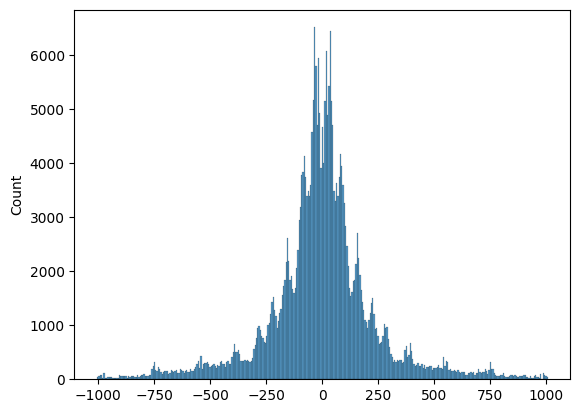

In [6]:
sns.histplot(graph.x)

<AxesSubplot: ylabel='Count'>

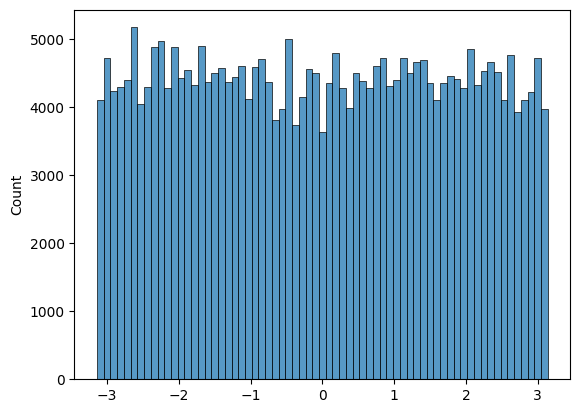

In [7]:
sns.histplot(graph.phi)

<AxesSubplot: ylabel='Count'>

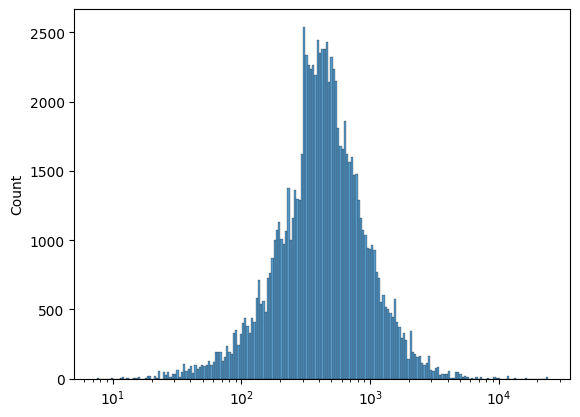

In [8]:
sns.histplot(graph.pt, log_scale=True)

<AxesSubplot: ylabel='Count'>

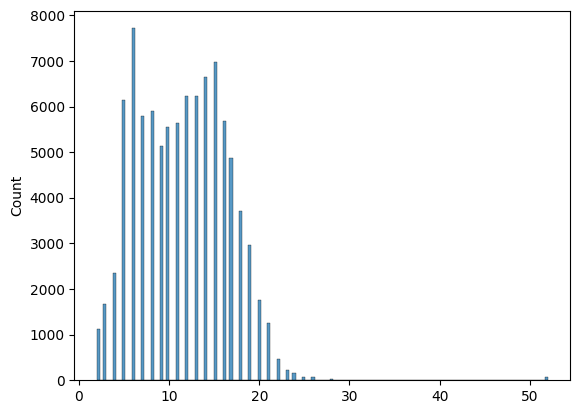

In [9]:
sns.histplot(graph.nhits)